In [1]:
#Problem 3: Route planning with probabilistic roadmaps

In [2]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import networkx as nx

In [3]:
# Read image from disk using PIL
occupancy_map_img = Image.open('../gridmaps/occupancy_map.png')

# Interpret this image as a numpy array, and threshold its values to→ {0,1}
occupancy_grid = (np.asarray(occupancy_map_img) > 0).astype(int)
occupancy_grid

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [4]:
#Test 1 - check if occupancy values are being read properly
print(type(occupancy_grid))
occ = occupancy_grid>0
np.where(occ == True)

<class 'numpy.ndarray'>


(array([ 31,  31,  31, ..., 676, 676, 676]),
 array([515, 517, 518, ...,  99, 100, 101]))

In [5]:
def sample(grid):
    """
    Function to sample integer points inside the map that lie in 
    the free region
    """
    
    rows, cols = grid.shape
    while True:
        r = np.random.randint(0, rows-1)
        c = np.random.randint(0, cols-1)
        if grid[r, c] == 1: # 1 indicates free space
            return (r, c)

In [6]:
def euclidean_h(pos_1, pos_2):
    """
    This function is used to calculate the eulcidean distance between 2 points.
    It is used as both the eedge weight and the heuristic h
    """
    euclidean_distance = np.linalg.norm(pos_1 - pos_2)
    return euclidean_distance

In [7]:
occ = np.where(occupancy_grid==0)
# occ.tolist()
# occ
# np.where(occ == True)
# np.where(occupancy_grid>0)
occ

(array([  0,   0,   0, ..., 679, 679, 679]),
 array([  0,   1,   2, ..., 620, 621, 622]))

In [8]:
def reachability_check(occupancy_grid, cell1, cell2):
    
    """
    The straight line generation is done by computing a Bresenham line
    between these cells. 
    This is a faster algorithm.
    The naive way to do it by seeing if the obstacle points are along
    the line connecting these cells. But it was taking 30+ minutes, 
    so, used the Bresenham's. The reference has been added to the function. 
    
    """
    
    x1, y1 = cell1
    x2, y2 = cell2

    # Compute Bresenham line between cells
    if x1 == x2:
        return False
    obstacle = bresenham(x1, y1, x2, y2)

    return obstacle


In [9]:
def bresenham(x1, y1, x2, y2):
    """
    https://github.com/daQuincy/Bresenham-Algorithm/blob/master/bresenham.py
    Bresenham's Line Generation Algorithm
    https://www.youtube.com/watch?v=76gp2IAazV4
    """
    
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    x, y = x1, y1
    sx = -1 if x1 > x2 else 1
    sy = -1 if y1 > y2 else 1
    if dx > dy:
        err = dx / 2.0
        while x != x2:
            if occupancy_grid[x][y] == 0:
                return False
            err -= dy
            if err < 0:
                y += sy
                err += dx
            x += sx
    else:
        err = dy / 2.0
        while y != y2:
            if occupancy_grid[x][y] == 0:
                return False
            err -= dx
            if err < 0:
                x += sx
                err += dy
            y += sy
    return True

In [10]:
def reachability_check_naive(occupancy_grid, cell1, cell2):
    
    """
    
    The naive way to do it by seeing if the obstacle points are along
    the line connecting these cells. But it was taking 30+ minutes, 
    so, used the Bresenham's. The reference has been added to the function. 
    
    """
    
    x_1, y_1 = cell1
    x_2, y_2 = cell2
    
    #list of all occupied cells
    occupied_cells = np.where(occupancy_grid==0)
    
    #straight line planner - define a stright line between these 2 points
    m = np.arctan2((y_2 - y_1), (x_2 - x_1))
    c = y_1 - m*x_1
    min_x = min(x_1, x_2)
    max_x = max(x_1, x_2)
    min_y = min(y_1, y_2)
    max_y = max(y_1, y_2)

    for x,y in zip(occupied_cells[0], occupied_cells[1]):
        if ((x<=max_x and x>=min_x) and (y>=min_y and y<=max_y)):
            rhs = m*x + c
            if y==rhs:
                return False

    return True


In [11]:
def d(pos_1, pos_2):
    """
    Function to caluclate the L2 norm between 2 points.
    """
    pos1 = np.array(pos_1)
    pos2 = np.array(pos_2)
    euclidean_distance = np.linalg.norm(pos1 - pos2)
    return euclidean_distance

In [12]:
def constructPRM(N, d_max):
    """
    Function to construct a PRM graph from an occupancy grid
    """

    G = nx.Graph()
    for k in tqdm(range(N)):
        #sample a new vertex
        vertex = sample(grid)
        AddVertex(G, vertex, d_max)
    return G
           

In [13]:
def AddVertex(G, v_new, d_max):
    """
    Function to add the sampled points to the graph and add edges if 
    they dont hit an obstacle along the way. 
    """
    
    #Add vertex v new to G
    G.add_node(v_new)
    for v in G.nodes:
        #Link v new to nearby vertices
        if v!=v_new and d(np.array(v),np.array(v_new))<d_max:
            
            #if planning succeeds
            if(reachability_check(grid,v_new, v)):
                
                #Add edge e = (v, v new ) to G
                weight = d(np.array(v),np.array(v_new))
                G.add_edge(v, tuple(v_new), weight=weight)

In [14]:
grid = occupancy_grid
G = constructPRM(3500, 75)

100%|███████████████████████████████████████████████████████████| 3500/3500 [00:22<00:00, 152.35it/s]


In [15]:
print("edges :", len(G.edges))
print("nodes :", len(G.nodes))

edges : 184593
nodes : 3462


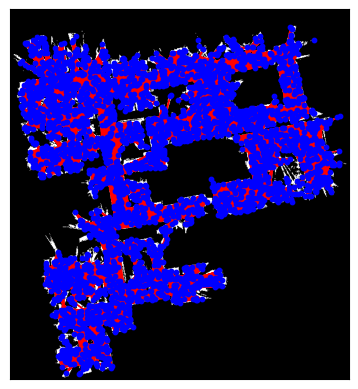

In [16]:
pos = {node: (node[1], node[0]) for node in G.nodes()}
nx.set_node_attributes(G, pos, 'pos')
nx.draw_networkx_edges(G, pos, edgelist=list(G.edges()), edge_color='red')
nx.draw_networkx_nodes(G, pos, node_size=10, node_color='blue')
plt.imshow(occupancy_grid, cmap = 'gray')
plt.axis("on") 
plt.show()


In [17]:
start = (635, 140)
goal = (350, 400)
G.add_node(start) 
G.add_node(goal)

In [18]:
# Use A* search to find a path from s to g
"""
But we wont be able to as we wont have edges connected to any of these
sampled points.
"""
# path = nx.astar_path(G, start, goal, heuristic=d)

'\nBut we wont be able to as we wont have edges connected to any of these\nsampled points.\n'

In [19]:
"""
Sample and add more vertices to G until start and goal 
are path-connected
"""

hasconnected = False
while not hasconnected:
    vertex = sample(occupancy_grid)
    AddVertex(G, vertex, 75)
    if nx.has_path(G,(635, 140), (350, 400)):
        hasconnected = True

In [20]:
# Use A* search to find a path from s to g
path = nx.astar_path(G, start, goal, heuristic=d)

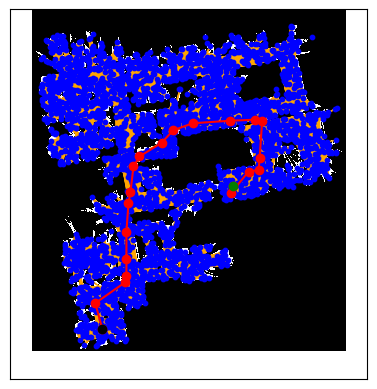

In [21]:
plt.imshow(occupancy_grid, cmap='gray', interpolation='none')

x = [point[1] for point in path]
y = [point[0] for point in path]
pos = {node: (node[1], node[0]) for node in G.nodes()}

nx.set_node_attributes(G, pos, 'pos')
nx.draw_networkx_edges(G, pos, edgelist=list(G.edges()), edge_color='orange')
nx.draw_networkx_nodes(G, pos, node_size=10, node_color='blue')

plt.plot(x, y, 'ro-')
plt.plot(start[1], start[0], 'ko')
plt.plot(goal[1], goal[0], 'go')
plt.show()

In [22]:
#length of the path 
len(path)

21

In [23]:
distance = np.sum(np.sqrt(np.sum(np.diff(path[1:], axis=0)**2, axis=1)))
distance

782.385362301159